In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=32, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         5152      
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_20 (Activation)   (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3724 - acc: 0.2485
Epoch 00001: val_loss improved from inf to 2.05899, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_3_conv_checkpoint/001-2.0590.hdf5
36805/36805 [==============================] - 25s 692us/sample - loss: 2.3722 - acc: 0.2485 - val_loss: 2.0590 - val_acc: 0.3527
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9163 - acc: 0.4064
Epoch 00002: val_loss improved from 2.05899 to 1.80020, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_3_conv_checkpoint/002-1.8002.hdf5
36805/36805 [==============================] - 23s 637us/sample - loss: 1.9164 - acc: 0.4063 - val_loss: 1.8002 - val_acc: 0.4442
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7114 - acc: 0.4710
Epoch 00003: val_loss improved from 1.80020 to 1.6509

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8351 - acc: 0.7364
Epoch 00023: val_loss did not improve from 1.30705
36805/36805 [==============================] - 23s 632us/sample - loss: 0.8351 - acc: 0.7364 - val_loss: 1.3119 - val_acc: 0.6173
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8158 - acc: 0.7422
Epoch 00024: val_loss improved from 1.30705 to 1.29349, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_3_conv_checkpoint/024-1.2935.hdf5
36805/36805 [==============================] - 23s 634us/sample - loss: 0.8158 - acc: 0.7422 - val_loss: 1.2935 - val_acc: 0.6210
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7947 - acc: 0.7466
Epoch 00025: val_loss did not improve from 1.29349
36805/36805 [==============================] - 23s 638us/sample - loss: 0.7947 - acc: 0.7466 - val_loss: 1.3252 - val_acc: 0.6131
Epoch 26/500
36800/36805 [============================>.] - ETA:

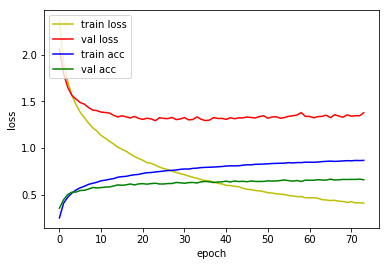

4815/4815 [==============================] - 2s 356us/sample - loss: 1.3766 - acc: 0.5836
Loss: 1.376645899041791 Accuracy: 0.58359295

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3993 - acc: 0.2274
Epoch 00001: val_loss improved from inf to 1.87964, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/001-1.8796.hdf5
36805/36805 [==============================] - 26s 702us/sample - loss: 2.3992 - acc: 0.2274 - val_loss: 1.8796 - val_acc: 0.4253
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7943 - acc: 0.4271
Epoch 00002: val_loss improved from 1.87964 to 1.60622, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/002-1.6062.hdf5
36805/36805 [==============================] - 24s 662us/sample - loss: 1.7943 - acc: 0.4271 - val_loss: 1.6062 - val_acc: 0.5076
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5548 - acc: 0.8218
Epoch 00048: val_loss did not improve from 0.78741
36805/36805 [==============================] - 24s 658us/sample - loss: 0.5548 - acc: 0.8218 - val_loss: 0.7951 - val_acc: 0.7729
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5439 - acc: 0.8263
Epoch 00049: val_loss did not improve from 0.78741
36805/36805 [==============================] - 24s 657us/sample - loss: 0.5440 - acc: 0.8263 - val_loss: 0.7925 - val_acc: 0.7773
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5431 - acc: 0.8275
Epoch 00050: val_loss improved from 0.78741 to 0.78327, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/050-0.7833.hdf5
36805/36805 [==============================] - 24s 664us/sample - loss: 0.5430 - acc: 0.8276 - val_loss: 0.7833 - val_acc: 0.7757
Epoch 51/500
36800/36805 [============================>.] - ETA:

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4367 - acc: 0.8584
Epoch 00076: val_loss did not improve from 0.75730
36805/36805 [==============================] - 24s 659us/sample - loss: 0.4367 - acc: 0.8584 - val_loss: 0.7718 - val_acc: 0.7815
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4390 - acc: 0.8562
Epoch 00077: val_loss did not improve from 0.75730
36805/36805 [==============================] - 24s 660us/sample - loss: 0.4389 - acc: 0.8562 - val_loss: 0.7720 - val_acc: 0.7873
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4389 - acc: 0.8585
Epoch 00078: val_loss did not improve from 0.75730
36805/36805 [==============================] - 24s 660us/sample - loss: 0.4388 - acc: 0.8585 - val_loss: 0.7673 - val_acc: 0.7866
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4293 - acc: 0.8594
Epoch 00079: val_loss did not improve from 0.75730
36805/36805 [=====

Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3865 - acc: 0.8722
Epoch 00105: val_loss improved from 0.74500 to 0.74002, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/105-0.7400.hdf5
36805/36805 [==============================] - 24s 662us/sample - loss: 0.3865 - acc: 0.8722 - val_loss: 0.7400 - val_acc: 0.8041
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3765 - acc: 0.8757
Epoch 00106: val_loss did not improve from 0.74002
36805/36805 [==============================] - 24s 661us/sample - loss: 0.3766 - acc: 0.8757 - val_loss: 0.7815 - val_acc: 0.7999
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3783 - acc: 0.8780
Epoch 00107: val_loss did not improve from 0.74002
36805/36805 [==============================] - 24s 661us/sample - loss: 0.3783 - acc: 0.8779 - val_loss: 0.7538 - val_acc: 0.8048
Epoch 108/500
36800/36805 [============================>.] - 

Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3473 - acc: 0.8848
Epoch 00134: val_loss did not improve from 0.73661
36805/36805 [==============================] - 24s 659us/sample - loss: 0.3473 - acc: 0.8848 - val_loss: 0.7389 - val_acc: 0.8146
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3397 - acc: 0.8882
Epoch 00135: val_loss did not improve from 0.73661
36805/36805 [==============================] - 24s 661us/sample - loss: 0.3397 - acc: 0.8882 - val_loss: 0.7518 - val_acc: 0.8060
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3457 - acc: 0.8874
Epoch 00136: val_loss did not improve from 0.73661
36805/36805 [==============================] - 24s 662us/sample - loss: 0.3457 - acc: 0.8874 - val_loss: 0.7829 - val_acc: 0.8025
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3383 - acc: 0.8874
Epoch 00137: val_loss did not improve from 0.73661
36805/36805 [=

Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3156 - acc: 0.8939
Epoch 00163: val_loss did not improve from 0.73427
36805/36805 [==============================] - 24s 658us/sample - loss: 0.3156 - acc: 0.8939 - val_loss: 0.7425 - val_acc: 0.8153
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3127 - acc: 0.8959
Epoch 00164: val_loss did not improve from 0.73427
36805/36805 [==============================] - 24s 656us/sample - loss: 0.3127 - acc: 0.8959 - val_loss: 0.7524 - val_acc: 0.8169
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3109 - acc: 0.8980
Epoch 00165: val_loss did not improve from 0.73427
36805/36805 [==============================] - 24s 657us/sample - loss: 0.3109 - acc: 0.8980 - val_loss: 0.7444 - val_acc: 0.8146
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3136 - acc: 0.8962
Epoch 00166: val_loss did not improve from 0.73427
36805/36805 [=

Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2987 - acc: 0.9014
Epoch 00192: val_loss did not improve from 0.73247
36805/36805 [==============================] - 24s 655us/sample - loss: 0.2986 - acc: 0.9015 - val_loss: 0.7444 - val_acc: 0.8188
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2923 - acc: 0.9048
Epoch 00193: val_loss did not improve from 0.73247
36805/36805 [==============================] - 24s 658us/sample - loss: 0.2923 - acc: 0.9048 - val_loss: 0.7523 - val_acc: 0.8206
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2928 - acc: 0.9016
Epoch 00194: val_loss did not improve from 0.73247
36805/36805 [==============================] - 24s 658us/sample - loss: 0.2928 - acc: 0.9016 - val_loss: 0.7439 - val_acc: 0.8181
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2918 - acc: 0.9032
Epoch 00195: val_loss did not improve from 0.73247
36805/36805 [=

Epoch 222/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2829 - acc: 0.9044
Epoch 00222: val_loss did not improve from 0.73247
36805/36805 [==============================] - 24s 655us/sample - loss: 0.2829 - acc: 0.9044 - val_loss: 0.7409 - val_acc: 0.8290
Epoch 223/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2784 - acc: 0.9073
Epoch 00223: val_loss improved from 0.73247 to 0.72979, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_4_conv_checkpoint/223-0.7298.hdf5
36805/36805 [==============================] - 24s 657us/sample - loss: 0.2784 - acc: 0.9073 - val_loss: 0.7298 - val_acc: 0.8234
Epoch 224/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2774 - acc: 0.9065
Epoch 00224: val_loss did not improve from 0.72979
36805/36805 [==============================] - 24s 657us/sample - loss: 0.2775 - acc: 0.9065 - val_loss: 0.7718 - val_acc: 0.8162
Epoch 225/500
36800/36805 [============================>.] - 

Epoch 251/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2608 - acc: 0.9125
Epoch 00251: val_loss did not improve from 0.71585
36805/36805 [==============================] - 24s 657us/sample - loss: 0.2608 - acc: 0.9125 - val_loss: 0.7449 - val_acc: 0.8283
Epoch 252/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2657 - acc: 0.9123
Epoch 00252: val_loss did not improve from 0.71585
36805/36805 [==============================] - 24s 657us/sample - loss: 0.2657 - acc: 0.9123 - val_loss: 0.7414 - val_acc: 0.8309
Epoch 253/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2658 - acc: 0.9129
Epoch 00253: val_loss did not improve from 0.71585
36805/36805 [==============================] - 24s 657us/sample - loss: 0.2658 - acc: 0.9129 - val_loss: 0.7451 - val_acc: 0.8248
Epoch 254/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2669 - acc: 0.9116
Epoch 00254: val_loss did not improve from 0.71585
36805/36805 [=

Epoch 281/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2566 - acc: 0.9152
Epoch 00281: val_loss did not improve from 0.71585
36805/36805 [==============================] - 24s 656us/sample - loss: 0.2566 - acc: 0.9153 - val_loss: 0.7320 - val_acc: 0.8321
Epoch 282/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2534 - acc: 0.9175
Epoch 00282: val_loss did not improve from 0.71585
36805/36805 [==============================] - 24s 654us/sample - loss: 0.2534 - acc: 0.9175 - val_loss: 0.7234 - val_acc: 0.8376
Epoch 283/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2515 - acc: 0.9173
Epoch 00283: val_loss did not improve from 0.71585
36805/36805 [==============================] - 24s 656us/sample - loss: 0.2515 - acc: 0.9173 - val_loss: 0.7269 - val_acc: 0.8351
Epoch 284/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2478 - acc: 0.9176
Epoch 00284: val_loss did not improve from 0.71585
36805/36805 [=

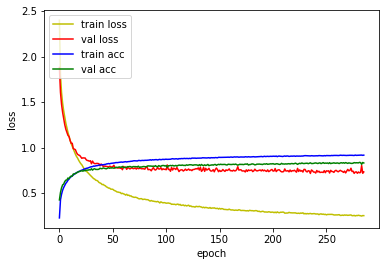

4815/4815 [==============================] - 2s 343us/sample - loss: 0.8170 - acc: 0.7985
Loss: 0.8169891846142825 Accuracy: 0.7985462

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3952 - acc: 0.2125
Epoch 00001: val_loss improved from inf to 1.84023, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/001-1.8402.hdf5
36805/36805 [==============================] - 27s 737us/sample - loss: 2.3951 - acc: 0.2126 - val_loss: 1.8402 - val_acc: 0.4177
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7927 - acc: 0.4113
Epoch 00002: val_loss improved from 1.84023 to 1.55220, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/002-1.5522.hdf5
36805/36805 [==============================] - 25s 672us/sample - loss: 1.7928 - acc: 0.4113 - val_loss: 1.5522 - val_acc: 0.5132
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7429 - acc: 0.7734
Epoch 00023: val_loss improved from 0.74458 to 0.73419, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/023-0.7342.hdf5
36805/36805 [==============================] - 25s 673us/sample - loss: 0.7429 - acc: 0.7733 - val_loss: 0.7342 - val_acc: 0.7939
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7332 - acc: 0.7754
Epoch 00024: val_loss did not improve from 0.73419
36805/36805 [==============================] - 25s 675us/sample - loss: 0.7331 - acc: 0.7755 - val_loss: 0.7414 - val_acc: 0.7801
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7207 - acc: 0.7790
Epoch 00025: val_loss improved from 0.73419 to 0.71833, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/025-0.7183.hdf5
36805/36805 [==============================] - 25s 676us/sample - loss: 0.7207 - acc: 0.7790

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5316 - acc: 0.8351
Epoch 00049: val_loss did not improve from 0.62300
36805/36805 [==============================] - 25s 671us/sample - loss: 0.5316 - acc: 0.8351 - val_loss: 0.6391 - val_acc: 0.8167
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5226 - acc: 0.8376
Epoch 00050: val_loss did not improve from 0.62300
36805/36805 [==============================] - 25s 671us/sample - loss: 0.5226 - acc: 0.8375 - val_loss: 0.6267 - val_acc: 0.8171
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5131 - acc: 0.8414
Epoch 00051: val_loss improved from 0.62300 to 0.60462, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_5_conv_checkpoint/051-0.6046.hdf5
36805/36805 [==============================] - 25s 673us/sample - loss: 0.5130 - acc: 0.8414 - val_loss: 0.6046 - val_acc: 0.8281
Epoch 52/500
36800/36805 [============================>.] - ETA:

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4172 - acc: 0.8686
Epoch 00077: val_loss did not improve from 0.57884
36805/36805 [==============================] - 25s 673us/sample - loss: 0.4172 - acc: 0.8686 - val_loss: 0.5841 - val_acc: 0.8402
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4233 - acc: 0.8661
Epoch 00078: val_loss did not improve from 0.57884
36805/36805 [==============================] - 25s 673us/sample - loss: 0.4233 - acc: 0.8661 - val_loss: 0.6067 - val_acc: 0.8330
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4172 - acc: 0.8681
Epoch 00079: val_loss did not improve from 0.57884
36805/36805 [==============================] - 25s 673us/sample - loss: 0.4171 - acc: 0.8681 - val_loss: 0.5797 - val_acc: 0.8425
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4141 - acc: 0.8674
Epoch 00080: val_loss did not improve from 0.57884
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.3233 - acc: 0.8959
Epoch 00133: val_loss did not improve from 0.54429
36805/36805 [==============================] - 25s 672us/sample - loss: 0.3233 - acc: 0.8959 - val_loss: 0.5493 - val_acc: 0.8584
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3177 - acc: 0.8961
Epoch 00134: val_loss did not improve from 0.54429
36805/36805 [==============================] - 25s 672us/sample - loss: 0.3177 - acc: 0.8961 - val_loss: 0.5673 - val_acc: 0.8542
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3204 - acc: 0.8962
Epoch 00135: val_loss did not improve from 0.54429
36805/36805 [==============================] - 25s 674us/sample - loss: 0.3203 - acc: 0.8962 - val_loss: 0.5609 - val_acc: 0.8514
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3221 - acc: 0.8945
Epoch 00136: val_loss did not improve from 0.54429
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.2967 - acc: 0.9027
Epoch 00162: val_loss did not improve from 0.54234
36805/36805 [==============================] - 25s 672us/sample - loss: 0.2968 - acc: 0.9027 - val_loss: 0.5600 - val_acc: 0.8609
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2937 - acc: 0.9047
Epoch 00163: val_loss did not improve from 0.54234
36805/36805 [==============================] - 25s 674us/sample - loss: 0.2938 - acc: 0.9047 - val_loss: 0.5516 - val_acc: 0.8598
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2921 - acc: 0.9033
Epoch 00164: val_loss did not improve from 0.54234
36805/36805 [==============================] - 25s 673us/sample - loss: 0.2921 - acc: 0.9033 - val_loss: 0.5556 - val_acc: 0.8579
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2887 - acc: 0.9049
Epoch 00165: val_loss did not improve from 0.54234
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.2736 - acc: 0.9101
Epoch 00191: val_loss did not improve from 0.53573
36805/36805 [==============================] - 25s 672us/sample - loss: 0.2735 - acc: 0.9101 - val_loss: 0.5536 - val_acc: 0.8614
Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2657 - acc: 0.9124
Epoch 00192: val_loss did not improve from 0.53573
36805/36805 [==============================] - 25s 672us/sample - loss: 0.2656 - acc: 0.9124 - val_loss: 0.5458 - val_acc: 0.8691
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2672 - acc: 0.9114
Epoch 00193: val_loss did not improve from 0.53573
36805/36805 [==============================] - 25s 673us/sample - loss: 0.2672 - acc: 0.9114 - val_loss: 0.5381 - val_acc: 0.8665
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2669 - acc: 0.9133
Epoch 00194: val_loss did not improve from 0.53573
36805/36805 [===============

Epoch 249/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2350 - acc: 0.9221
Epoch 00249: val_loss did not improve from 0.52918
36805/36805 [==============================] - 25s 671us/sample - loss: 0.2350 - acc: 0.9221 - val_loss: 0.5414 - val_acc: 0.8730
Epoch 250/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2340 - acc: 0.9234
Epoch 00250: val_loss did not improve from 0.52918
36805/36805 [==============================] - 25s 673us/sample - loss: 0.2340 - acc: 0.9234 - val_loss: 0.5566 - val_acc: 0.8649
Epoch 251/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2392 - acc: 0.9211
Epoch 00251: val_loss did not improve from 0.52918
36805/36805 [==============================] - 25s 673us/sample - loss: 0.2391 - acc: 0.9211 - val_loss: 0.5705 - val_acc: 0.8614
Epoch 252/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2389 - acc: 0.9204
Epoch 00252: val_loss did not improve from 0.52918
36805/36805 [=

Epoch 307/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2138 - acc: 0.9297
Epoch 00307: val_loss did not improve from 0.51549
36805/36805 [==============================] - 25s 672us/sample - loss: 0.2138 - acc: 0.9297 - val_loss: 0.5239 - val_acc: 0.8791
Epoch 308/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2166 - acc: 0.9281
Epoch 00308: val_loss did not improve from 0.51549
36805/36805 [==============================] - 25s 676us/sample - loss: 0.2166 - acc: 0.9281 - val_loss: 0.5399 - val_acc: 0.8803
Epoch 309/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2143 - acc: 0.9293
Epoch 00309: val_loss did not improve from 0.51549
36805/36805 [==============================] - 25s 672us/sample - loss: 0.2143 - acc: 0.9292 - val_loss: 0.5353 - val_acc: 0.8733
Epoch 310/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2148 - acc: 0.9301
Epoch 00310: val_loss did not improve from 0.51549
36805/36805 [=

Epoch 336/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2038 - acc: 0.9326
Epoch 00336: val_loss did not improve from 0.51312
36805/36805 [==============================] - 25s 672us/sample - loss: 0.2039 - acc: 0.9326 - val_loss: 0.5399 - val_acc: 0.8782
Epoch 337/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2047 - acc: 0.9340
Epoch 00337: val_loss did not improve from 0.51312
36805/36805 [==============================] - 25s 671us/sample - loss: 0.2047 - acc: 0.9341 - val_loss: 0.5432 - val_acc: 0.8765
Epoch 338/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2054 - acc: 0.9340
Epoch 00338: val_loss did not improve from 0.51312
36805/36805 [==============================] - 25s 677us/sample - loss: 0.2054 - acc: 0.9340 - val_loss: 0.5184 - val_acc: 0.8838
Epoch 339/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2005 - acc: 0.9352
Epoch 00339: val_loss did not improve from 0.51312
36805/36805 [=

Epoch 366/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1944 - acc: 0.9346
Epoch 00366: val_loss did not improve from 0.51312
36805/36805 [==============================] - 25s 673us/sample - loss: 0.1945 - acc: 0.9345 - val_loss: 0.5378 - val_acc: 0.8798
Epoch 367/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9343
Epoch 00367: val_loss did not improve from 0.51312
36805/36805 [==============================] - 25s 672us/sample - loss: 0.1983 - acc: 0.9344 - val_loss: 0.5266 - val_acc: 0.8828
Epoch 368/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1958 - acc: 0.9350
Epoch 00368: val_loss did not improve from 0.51312
36805/36805 [==============================] - 25s 672us/sample - loss: 0.1958 - acc: 0.9350 - val_loss: 0.5319 - val_acc: 0.8810
Epoch 369/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1972 - acc: 0.9363
Epoch 00369: val_loss did not improve from 0.51312
36805/36805 [=

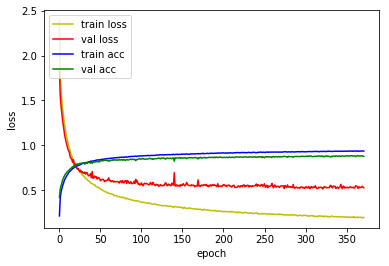

4815/4815 [==============================] - 2s 363us/sample - loss: 0.6188 - acc: 0.8434
Loss: 0.6188230420693925 Accuracy: 0.843406

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6168 - acc: 0.1318
Epoch 00001: val_loss improved from inf to 2.21888, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/001-2.2189.hdf5
36805/36805 [==============================] - 29s 786us/sample - loss: 2.6169 - acc: 0.1318 - val_loss: 2.2189 - val_acc: 0.3075
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9995 - acc: 0.3473
Epoch 00002: val_loss improved from 2.21888 to 1.61326, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/002-1.6133.hdf5
36805/36805 [==============================] - 25s 691us/sample - loss: 1.9994 - acc: 0.3473 - val_loss: 1.6133 - val_acc: 0.5073
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7345 - acc: 0.7780
Epoch 00023: val_loss did not improve from 0.62383
36805/36805 [==============================] - 25s 689us/sample - loss: 0.7345 - acc: 0.7780 - val_loss: 0.6696 - val_acc: 0.8104
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7228 - acc: 0.7811
Epoch 00024: val_loss did not improve from 0.62383
36805/36805 [==============================] - 25s 690us/sample - loss: 0.7228 - acc: 0.7811 - val_loss: 0.6459 - val_acc: 0.8125
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7071 - acc: 0.7866
Epoch 00025: val_loss improved from 0.62383 to 0.60486, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/025-0.6049.hdf5
36805/36805 [==============================] - 25s 692us/sample - loss: 0.7074 - acc: 0.7866 - val_loss: 0.6049 - val_acc: 0.8262
Epoch 26/500
36800/36805 [============================>.] - ETA:

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5147 - acc: 0.8448
Epoch 00047: val_loss improved from 0.43411 to 0.42430, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/047-0.4243.hdf5
36805/36805 [==============================] - 26s 693us/sample - loss: 0.5146 - acc: 0.8448 - val_loss: 0.4243 - val_acc: 0.8863
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5082 - acc: 0.8474
Epoch 00048: val_loss did not improve from 0.42430
36805/36805 [==============================] - 25s 690us/sample - loss: 0.5083 - acc: 0.8474 - val_loss: 0.4304 - val_acc: 0.8845
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5028 - acc: 0.8477
Epoch 00049: val_loss did not improve from 0.42430
36805/36805 [==============================] - 25s 690us/sample - loss: 0.5029 - acc: 0.8477 - val_loss: 0.4248 - val_acc: 0.8868
Epoch 50/500
36800/36805 [============================>.] - ETA:

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4106 - acc: 0.8745
Epoch 00073: val_loss did not improve from 0.35225
36805/36805 [==============================] - 25s 691us/sample - loss: 0.4107 - acc: 0.8745 - val_loss: 0.3555 - val_acc: 0.9054
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4040 - acc: 0.8760
Epoch 00074: val_loss did not improve from 0.35225
36805/36805 [==============================] - 25s 690us/sample - loss: 0.4040 - acc: 0.8760 - val_loss: 0.3635 - val_acc: 0.9015
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4078 - acc: 0.8733
Epoch 00075: val_loss improved from 0.35225 to 0.34535, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/075-0.3454.hdf5
36805/36805 [==============================] - 25s 692us/sample - loss: 0.4078 - acc: 0.8734 - val_loss: 0.3454 - val_acc: 0.9087
Epoch 76/500
36800/36805 [============================>.] - ETA:

Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3111 - acc: 0.9010
Epoch 00126: val_loss improved from 0.30764 to 0.30619, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/126-0.3062.hdf5
36805/36805 [==============================] - 25s 681us/sample - loss: 0.3111 - acc: 0.9010 - val_loss: 0.3062 - val_acc: 0.9227
Epoch 127/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3124 - acc: 0.9018
Epoch 00127: val_loss did not improve from 0.30619
36805/36805 [==============================] - 25s 678us/sample - loss: 0.3124 - acc: 0.9018 - val_loss: 0.3197 - val_acc: 0.9157
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3181 - acc: 0.8998
Epoch 00128: val_loss did not improve from 0.30619
36805/36805 [==============================] - 25s 680us/sample - loss: 0.3180 - acc: 0.8998 - val_loss: 0.3107 - val_acc: 0.9189
Epoch 129/500
36800/36805 [============================>.] - 

Epoch 182/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2615 - acc: 0.9152
Epoch 00182: val_loss did not improve from 0.28361
36805/36805 [==============================] - 25s 692us/sample - loss: 0.2616 - acc: 0.9152 - val_loss: 0.3146 - val_acc: 0.9252
Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2592 - acc: 0.9162
Epoch 00183: val_loss improved from 0.28361 to 0.28126, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_6_conv_checkpoint/183-0.2813.hdf5
36805/36805 [==============================] - 26s 693us/sample - loss: 0.2591 - acc: 0.9162 - val_loss: 0.2813 - val_acc: 0.9283
Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2599 - acc: 0.9166
Epoch 00184: val_loss did not improve from 0.28126
36805/36805 [==============================] - 25s 691us/sample - loss: 0.2599 - acc: 0.9166 - val_loss: 0.2884 - val_acc: 0.9259
Epoch 185/500
36800/36805 [============================>.] - 

Epoch 211/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2363 - acc: 0.9237
Epoch 00211: val_loss did not improve from 0.27496
36805/36805 [==============================] - 25s 691us/sample - loss: 0.2363 - acc: 0.9237 - val_loss: 0.2804 - val_acc: 0.9266
Epoch 212/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2447 - acc: 0.9218
Epoch 00212: val_loss did not improve from 0.27496
36805/36805 [==============================] - 25s 692us/sample - loss: 0.2447 - acc: 0.9219 - val_loss: 0.2813 - val_acc: 0.9280
Epoch 213/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2396 - acc: 0.9218
Epoch 00213: val_loss did not improve from 0.27496
36805/36805 [==============================] - 25s 690us/sample - loss: 0.2395 - acc: 0.9218 - val_loss: 0.3057 - val_acc: 0.9273
Epoch 214/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2438 - acc: 0.9210
Epoch 00214: val_loss did not improve from 0.27496
36805/36805 [=

Epoch 240/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2243 - acc: 0.9273
Epoch 00240: val_loss did not improve from 0.27326
36805/36805 [==============================] - 25s 690us/sample - loss: 0.2243 - acc: 0.9273 - val_loss: 0.2824 - val_acc: 0.9248
Epoch 241/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2196 - acc: 0.9287
Epoch 00241: val_loss did not improve from 0.27326
36805/36805 [==============================] - 25s 690us/sample - loss: 0.2195 - acc: 0.9287 - val_loss: 0.2986 - val_acc: 0.9262
Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2276 - acc: 0.9234
Epoch 00242: val_loss did not improve from 0.27326
36805/36805 [==============================] - 25s 691us/sample - loss: 0.2276 - acc: 0.9234 - val_loss: 0.2842 - val_acc: 0.9210
Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2210 - acc: 0.9269
Epoch 00243: val_loss did not improve from 0.27326
36805/36805 [=

Epoch 269/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2118 - acc: 0.9298
Epoch 00269: val_loss did not improve from 0.27170
36805/36805 [==============================] - 25s 690us/sample - loss: 0.2118 - acc: 0.9298 - val_loss: 0.2866 - val_acc: 0.9283
Epoch 270/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2119 - acc: 0.9312
Epoch 00270: val_loss did not improve from 0.27170
36805/36805 [==============================] - 25s 691us/sample - loss: 0.2118 - acc: 0.9312 - val_loss: 0.2933 - val_acc: 0.9280
Epoch 271/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2081 - acc: 0.9303
Epoch 00271: val_loss did not improve from 0.27170
36805/36805 [==============================] - 25s 690us/sample - loss: 0.2080 - acc: 0.9303 - val_loss: 0.2797 - val_acc: 0.9297
Epoch 272/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2108 - acc: 0.9304
Epoch 00272: val_loss did not improve from 0.27170
36805/36805 [=

Epoch 298/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2001 - acc: 0.9349
Epoch 00298: val_loss did not improve from 0.26885
36805/36805 [==============================] - 25s 691us/sample - loss: 0.2001 - acc: 0.9349 - val_loss: 0.2890 - val_acc: 0.9271
Epoch 299/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1970 - acc: 0.9357
Epoch 00299: val_loss did not improve from 0.26885
36805/36805 [==============================] - 25s 691us/sample - loss: 0.1970 - acc: 0.9357 - val_loss: 0.2750 - val_acc: 0.9313
Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1940 - acc: 0.9361
Epoch 00300: val_loss did not improve from 0.26885
36805/36805 [==============================] - 25s 691us/sample - loss: 0.1940 - acc: 0.9360 - val_loss: 0.2699 - val_acc: 0.9301
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1953 - acc: 0.9358
Epoch 00301: val_loss did not improve from 0.26885
36805/36805 [=

Epoch 327/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1909 - acc: 0.9371
Epoch 00327: val_loss did not improve from 0.26847
36805/36805 [==============================] - 25s 691us/sample - loss: 0.1909 - acc: 0.9371 - val_loss: 0.2780 - val_acc: 0.9324
Epoch 328/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9395
Epoch 00328: val_loss did not improve from 0.26847
36805/36805 [==============================] - 25s 691us/sample - loss: 0.1852 - acc: 0.9395 - val_loss: 0.2912 - val_acc: 0.9343
Epoch 329/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1862 - acc: 0.9386
Epoch 00329: val_loss did not improve from 0.26847
36805/36805 [==============================] - 25s 692us/sample - loss: 0.1861 - acc: 0.9386 - val_loss: 0.2890 - val_acc: 0.9324
Epoch 330/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1893 - acc: 0.9378
Epoch 00330: val_loss did not improve from 0.26847
36805/36805 [=

Epoch 357/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1743 - acc: 0.9423
Epoch 00357: val_loss did not improve from 0.26847
36805/36805 [==============================] - 25s 691us/sample - loss: 0.1743 - acc: 0.9423 - val_loss: 0.2895 - val_acc: 0.9285
Epoch 358/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1836 - acc: 0.9390
Epoch 00358: val_loss did not improve from 0.26847
36805/36805 [==============================] - 25s 692us/sample - loss: 0.1836 - acc: 0.9390 - val_loss: 0.2829 - val_acc: 0.9345
Epoch 359/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1757 - acc: 0.9420
Epoch 00359: val_loss did not improve from 0.26847
36805/36805 [==============================] - 25s 691us/sample - loss: 0.1757 - acc: 0.9419 - val_loss: 0.3035 - val_acc: 0.9306
Epoch 360/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1818 - acc: 0.9395
Epoch 00360: val_loss did not improve from 0.26847
36805/36805 [=

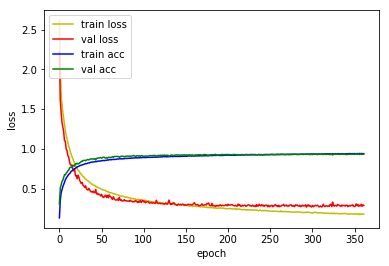

4815/4815 [==============================] - 2s 389us/sample - loss: 0.3242 - acc: 0.9101
Loss: 0.32421576377634936 Accuracy: 0.9100727

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6846 - acc: 0.1058
Epoch 00001: val_loss improved from inf to 2.48453, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/001-2.4845.hdf5
36805/36805 [==============================] - 30s 822us/sample - loss: 2.6846 - acc: 0.1058 - val_loss: 2.4845 - val_acc: 0.2103
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2768 - acc: 0.2481
Epoch 00002: val_loss improved from 2.48453 to 1.81876, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/002-1.8188.hdf5
36805/36805 [==============================] - 26s 712us/sample - loss: 2.2767 - acc: 0.2481 - val_loss: 1.8188 - val_acc: 0.4342
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7371 - acc: 0.7738
Epoch 00023: val_loss improved from 0.58036 to 0.52287, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/023-0.5229.hdf5
36805/36805 [==============================] - 26s 713us/sample - loss: 0.7371 - acc: 0.7738 - val_loss: 0.5229 - val_acc: 0.8528
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7160 - acc: 0.7818
Epoch 00024: val_loss improved from 0.52287 to 0.50120, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/024-0.5012.hdf5
36805/36805 [==============================] - 26s 711us/sample - loss: 0.7160 - acc: 0.7819 - val_loss: 0.5012 - val_acc: 0.8616
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6990 - acc: 0.7848
Epoch 00025: val_loss improved from 0.50120 to 0.50091, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/025-0.

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4910 - acc: 0.8472
Epoch 00047: val_loss improved from 0.32162 to 0.32151, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/047-0.3215.hdf5
36805/36805 [==============================] - 26s 714us/sample - loss: 0.4909 - acc: 0.8472 - val_loss: 0.3215 - val_acc: 0.9106
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4872 - acc: 0.8509
Epoch 00048: val_loss improved from 0.32151 to 0.30819, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_7_conv_checkpoint/048-0.3082.hdf5
36805/36805 [==============================] - 26s 713us/sample - loss: 0.4872 - acc: 0.8509 - val_loss: 0.3082 - val_acc: 0.9143
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4865 - acc: 0.8519
Epoch 00049: val_loss did not improve from 0.30819
36805/36805 [==============================] - 26s 712us/sample - loss: 0.4864 - acc: 0.8519

Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3986 - acc: 0.8773
Epoch 00071: val_loss did not improve from 0.25049
36805/36805 [==============================] - 26s 711us/sample - loss: 0.3985 - acc: 0.8774 - val_loss: 0.2586 - val_acc: 0.9336
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3949 - acc: 0.8773
Epoch 00072: val_loss did not improve from 0.25049
36805/36805 [==============================] - 26s 710us/sample - loss: 0.3949 - acc: 0.8773 - val_loss: 0.2700 - val_acc: 0.9250
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3948 - acc: 0.8772
Epoch 00073: val_loss did not improve from 0.25049
36805/36805 [==============================] - 26s 709us/sample - loss: 0.3948 - acc: 0.8772 - val_loss: 0.2598 - val_acc: 0.9304
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3901 - acc: 0.8779
Epoch 00074: val_loss improved from 0.25049 to 0.24669, saving model 

Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3346 - acc: 0.8944
Epoch 00098: val_loss did not improve from 0.20870
36805/36805 [==============================] - 26s 712us/sample - loss: 0.3348 - acc: 0.8943 - val_loss: 0.2326 - val_acc: 0.9371
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3372 - acc: 0.8952
Epoch 00099: val_loss did not improve from 0.20870
36805/36805 [==============================] - 26s 713us/sample - loss: 0.3372 - acc: 0.8952 - val_loss: 0.2256 - val_acc: 0.9422
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3241 - acc: 0.8965
Epoch 00100: val_loss did not improve from 0.20870
36805/36805 [==============================] - 26s 712us/sample - loss: 0.3241 - acc: 0.8965 - val_loss: 0.2169 - val_acc: 0.9420
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3244 - acc: 0.8990
Epoch 00101: val_loss did not improve from 0.20870
36805/36805 [===

Epoch 154/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2565 - acc: 0.9189
Epoch 00154: val_loss did not improve from 0.18733
36805/36805 [==============================] - 26s 712us/sample - loss: 0.2565 - acc: 0.9189 - val_loss: 0.1982 - val_acc: 0.9483
Epoch 155/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2555 - acc: 0.9182
Epoch 00155: val_loss did not improve from 0.18733
36805/36805 [==============================] - 26s 711us/sample - loss: 0.2557 - acc: 0.9182 - val_loss: 0.1974 - val_acc: 0.9492
Epoch 156/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2597 - acc: 0.9170
Epoch 00156: val_loss did not improve from 0.18733
36805/36805 [==============================] - 26s 713us/sample - loss: 0.2597 - acc: 0.9170 - val_loss: 0.1915 - val_acc: 0.9506
Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2477 - acc: 0.9191
Epoch 00157: val_loss did not improve from 0.18733
36805/36805 [=

Epoch 182/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2299 - acc: 0.9259
Epoch 00182: val_loss did not improve from 0.18032
36805/36805 [==============================] - 26s 712us/sample - loss: 0.2299 - acc: 0.9259 - val_loss: 0.1826 - val_acc: 0.9532
Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2255 - acc: 0.9285
Epoch 00183: val_loss did not improve from 0.18032
36805/36805 [==============================] - 26s 712us/sample - loss: 0.2255 - acc: 0.9285 - val_loss: 0.1940 - val_acc: 0.9520
Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2251 - acc: 0.9271
Epoch 00184: val_loss did not improve from 0.18032
36805/36805 [==============================] - 26s 712us/sample - loss: 0.2252 - acc: 0.9271 - val_loss: 0.1884 - val_acc: 0.9511
Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2228 - acc: 0.9285
Epoch 00185: val_loss did not improve from 0.18032
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.1807 - acc: 0.9401
Epoch 00239: val_loss did not improve from 0.17317
36805/36805 [==============================] - 26s 714us/sample - loss: 0.1807 - acc: 0.9401 - val_loss: 0.1837 - val_acc: 0.9576
Epoch 240/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1830 - acc: 0.9402
Epoch 00240: val_loss did not improve from 0.17317
36805/36805 [==============================] - 26s 713us/sample - loss: 0.1830 - acc: 0.9402 - val_loss: 0.1841 - val_acc: 0.9548
Epoch 241/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1825 - acc: 0.9389
Epoch 00241: val_loss did not improve from 0.17317
36805/36805 [==============================] - 26s 712us/sample - loss: 0.1827 - acc: 0.9389 - val_loss: 0.1785 - val_acc: 0.9520
Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1829 - acc: 0.9397
Epoch 00242: val_loss did not improve from 0.17317
36805/36805 [===============

36800/36805 [============================>.] - ETA: 0s - loss: 0.1674 - acc: 0.9447
Epoch 00268: val_loss did not improve from 0.17224
36805/36805 [==============================] - 26s 711us/sample - loss: 0.1674 - acc: 0.9447 - val_loss: 0.1807 - val_acc: 0.9546
Epoch 269/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1668 - acc: 0.9448
Epoch 00269: val_loss did not improve from 0.17224
36805/36805 [==============================] - 26s 713us/sample - loss: 0.1668 - acc: 0.9448 - val_loss: 0.1829 - val_acc: 0.9532
Epoch 270/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1685 - acc: 0.9429
Epoch 00270: val_loss did not improve from 0.17224
36805/36805 [==============================] - 26s 712us/sample - loss: 0.1685 - acc: 0.9429 - val_loss: 0.1780 - val_acc: 0.9529
Epoch 271/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1735 - acc: 0.9416
Epoch 00271: val_loss did not improve from 0.17224
36805/36805 [===============

Epoch 298/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1568 - acc: 0.9467
Epoch 00298: val_loss did not improve from 0.17224
36805/36805 [==============================] - 26s 713us/sample - loss: 0.1568 - acc: 0.9467 - val_loss: 0.1790 - val_acc: 0.9569
Epoch 299/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1514 - acc: 0.9504
Epoch 00299: val_loss did not improve from 0.17224
36805/36805 [==============================] - 26s 713us/sample - loss: 0.1514 - acc: 0.9504 - val_loss: 0.1825 - val_acc: 0.9539
Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1503 - acc: 0.9499
Epoch 00300: val_loss did not improve from 0.17224
36805/36805 [==============================] - 26s 712us/sample - loss: 0.1503 - acc: 0.9499 - val_loss: 0.2011 - val_acc: 0.9525
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1527 - acc: 0.9488
Epoch 00301: val_loss did not improve from 0.17224
36805/36805 [=

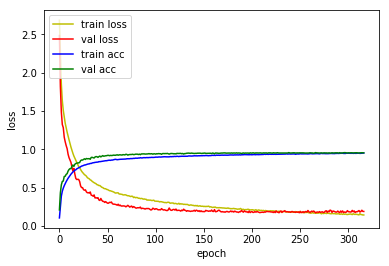

4815/4815 [==============================] - 2s 423us/sample - loss: 0.1965 - acc: 0.9448
Loss: 0.19645620453889992 Accuracy: 0.944756

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6600 - acc: 0.1160
Epoch 00001: val_loss improved from inf to 2.22986, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_8_conv_checkpoint/001-2.2299.hdf5
36805/36805 [==============================] - 32s 866us/sample - loss: 2.6600 - acc: 0.1160 - val_loss: 2.2299 - val_acc: 0.3051
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1306 - acc: 0.2978
Epoch 00002: val_loss improved from 2.22986 to 1.67703, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_8_conv_checkpoint/002-1.6770.hdf5
36805/36805 [==============================] - 27s 736us/sample - loss: 2.1305 - acc: 0.2978 - val_loss: 1.6770 - val_acc: 0.5139
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6667 - acc: 0.7871
Epoch 00023: val_loss improved from 0.43702 to 0.38021, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_8_conv_checkpoint/023-0.3802.hdf5
36805/36805 [==============================] - 27s 736us/sample - loss: 0.6666 - acc: 0.7871 - val_loss: 0.3802 - val_acc: 0.8854
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6552 - acc: 0.7943
Epoch 00024: val_loss improved from 0.38021 to 0.37371, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_8_conv_checkpoint/024-0.3737.hdf5
36805/36805 [==============================] - 27s 735us/sample - loss: 0.6551 - acc: 0.7943 - val_loss: 0.3737 - val_acc: 0.8901
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6361 - acc: 0.7977
Epoch 00025: val_loss improved from 0.37371 to 0.35791, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_8_conv_checkpoint/025-0.

Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4457 - acc: 0.8614
Epoch 00046: val_loss did not improve from 0.24047
36805/36805 [==============================] - 27s 734us/sample - loss: 0.4458 - acc: 0.8614 - val_loss: 0.2499 - val_acc: 0.9320
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4419 - acc: 0.8626
Epoch 00047: val_loss improved from 0.24047 to 0.22496, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_8_conv_checkpoint/047-0.2250.hdf5
36805/36805 [==============================] - 27s 735us/sample - loss: 0.4419 - acc: 0.8626 - val_loss: 0.2250 - val_acc: 0.9392
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4351 - acc: 0.8655
Epoch 00048: val_loss improved from 0.22496 to 0.22010, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_8_conv_checkpoint/048-0.2201.hdf5
36805/36805 [==============================] - 27s 734us/sample - loss: 0.4350 - acc: 0.8655

Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2676 - acc: 0.9151
Epoch 00097: val_loss did not improve from 0.15123
36805/36805 [==============================] - 27s 733us/sample - loss: 0.2676 - acc: 0.9151 - val_loss: 0.1573 - val_acc: 0.9536
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2686 - acc: 0.9144
Epoch 00098: val_loss did not improve from 0.15123
36805/36805 [==============================] - 27s 734us/sample - loss: 0.2686 - acc: 0.9144 - val_loss: 0.1562 - val_acc: 0.9541
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2612 - acc: 0.9180
Epoch 00099: val_loss did not improve from 0.15123
36805/36805 [==============================] - 27s 733us/sample - loss: 0.2612 - acc: 0.9180 - val_loss: 0.1644 - val_acc: 0.9509
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2649 - acc: 0.9158
Epoch 00100: val_loss did not improve from 0.15123
36805/36805 [====

Epoch 125/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2213 - acc: 0.9287
Epoch 00125: val_loss did not improve from 0.13973
36805/36805 [==============================] - 27s 734us/sample - loss: 0.2213 - acc: 0.9288 - val_loss: 0.1420 - val_acc: 0.9576
Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2221 - acc: 0.9287
Epoch 00126: val_loss did not improve from 0.13973
36805/36805 [==============================] - 27s 735us/sample - loss: 0.2221 - acc: 0.9287 - val_loss: 0.1486 - val_acc: 0.9588
Epoch 127/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2142 - acc: 0.9317
Epoch 00127: val_loss did not improve from 0.13973
36805/36805 [==============================] - 27s 733us/sample - loss: 0.2142 - acc: 0.9317 - val_loss: 0.1507 - val_acc: 0.9562
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9310
Epoch 00128: val_loss did not improve from 0.13973
36805/36805 [=

Epoch 154/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9393
Epoch 00154: val_loss did not improve from 0.13758
36805/36805 [==============================] - 27s 732us/sample - loss: 0.1850 - acc: 0.9394 - val_loss: 0.1569 - val_acc: 0.9553
Epoch 155/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1809 - acc: 0.9416
Epoch 00155: val_loss did not improve from 0.13758
36805/36805 [==============================] - 27s 735us/sample - loss: 0.1809 - acc: 0.9416 - val_loss: 0.1493 - val_acc: 0.9611
Epoch 156/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1815 - acc: 0.9425
Epoch 00156: val_loss did not improve from 0.13758
36805/36805 [==============================] - 27s 734us/sample - loss: 0.1814 - acc: 0.9425 - val_loss: 0.1479 - val_acc: 0.9592
Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1854 - acc: 0.9398
Epoch 00157: val_loss did not improve from 0.13758
36805/36805 [=

Epoch 183/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1546 - acc: 0.9480
Epoch 00183: val_loss did not improve from 0.13151
36805/36805 [==============================] - 27s 737us/sample - loss: 0.1546 - acc: 0.9481 - val_loss: 0.1398 - val_acc: 0.9588
Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1552 - acc: 0.9485
Epoch 00184: val_loss did not improve from 0.13151
36805/36805 [==============================] - 27s 734us/sample - loss: 0.1552 - acc: 0.9485 - val_loss: 0.1407 - val_acc: 0.9620
Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1547 - acc: 0.9483
Epoch 00185: val_loss did not improve from 0.13151
36805/36805 [==============================] - 27s 732us/sample - loss: 0.1547 - acc: 0.9483 - val_loss: 0.1393 - val_acc: 0.9637
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1489 - acc: 0.9514
Epoch 00186: val_loss did not improve from 0.13151
36805/36805 [=

Epoch 212/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1384 - acc: 0.9529
Epoch 00212: val_loss did not improve from 0.13044
36805/36805 [==============================] - 27s 734us/sample - loss: 0.1384 - acc: 0.9529 - val_loss: 0.1523 - val_acc: 0.9581
Epoch 213/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1296 - acc: 0.9561
Epoch 00213: val_loss did not improve from 0.13044
36805/36805 [==============================] - 27s 733us/sample - loss: 0.1296 - acc: 0.9561 - val_loss: 0.1408 - val_acc: 0.9637
Epoch 214/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1348 - acc: 0.9540
Epoch 00214: val_loss did not improve from 0.13044
36805/36805 [==============================] - 27s 735us/sample - loss: 0.1347 - acc: 0.9540 - val_loss: 0.1483 - val_acc: 0.9616
Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1347 - acc: 0.9555
Epoch 00215: val_loss did not improve from 0.13044
36805/36805 [=

Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1161 - acc: 0.9611
Epoch 00242: val_loss did not improve from 0.13044
36805/36805 [==============================] - 26s 710us/sample - loss: 0.1161 - acc: 0.9611 - val_loss: 0.1482 - val_acc: 0.9632
Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.9618
Epoch 00243: val_loss did not improve from 0.13044
36805/36805 [==============================] - 27s 730us/sample - loss: 0.1127 - acc: 0.9618 - val_loss: 0.1453 - val_acc: 0.9606
Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1155 - acc: 0.9610
Epoch 00244: val_loss did not improve from 0.13044
36805/36805 [==============================] - 27s 725us/sample - loss: 0.1155 - acc: 0.9610 - val_loss: 0.1385 - val_acc: 0.9632
Epoch 245/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9623
Epoch 00245: val_loss did not improve from 0.13044
36805/36805 [=

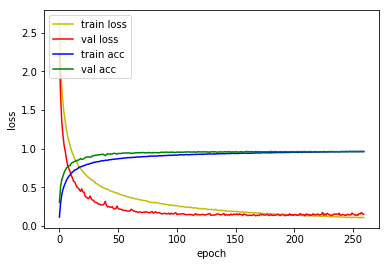

4815/4815 [==============================] - 2s 379us/sample - loss: 0.1899 - acc: 0.9479
Loss: 0.18992123000540403 Accuracy: 0.9478712

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5379 - acc: 0.1738
Epoch 00001: val_loss improved from inf to 1.92672, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_9_conv_checkpoint/001-1.9267.hdf5
36805/36805 [==============================] - 33s 883us/sample - loss: 2.5378 - acc: 0.1739 - val_loss: 1.9267 - val_acc: 0.4416
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8338 - acc: 0.4126
Epoch 00002: val_loss improved from 1.92672 to 1.26491, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_9_conv_checkpoint/002-1.2649.hdf5
36805/36805 [==============================] - 27s 736us/sample - loss: 1.8339 - acc: 0.4126 - val_loss: 1.2649 - val_acc: 0.6194
Epoch 3/500
36736/36805 [============================>.] - E

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4118 - acc: 0.8714
Epoch 00023: val_loss did not improve from 0.25310
36805/36805 [==============================] - 27s 728us/sample - loss: 0.4119 - acc: 0.8713 - val_loss: 0.2584 - val_acc: 0.9203
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4024 - acc: 0.8741
Epoch 00024: val_loss improved from 0.25310 to 0.24340, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_9_conv_checkpoint/024-0.2434.hdf5
36805/36805 [==============================] - 27s 735us/sample - loss: 0.4024 - acc: 0.8741 - val_loss: 0.2434 - val_acc: 0.9276
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3834 - acc: 0.8795
Epoch 00025: val_loss improved from 0.24340 to 0.21994, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_9_conv_checkpoint/025-0.2199.hdf5
36805/36805 [==============================] - 27s 736us/sample - loss: 0.3834 - acc: 0.8794

Epoch 75/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1441 - acc: 0.9527
Epoch 00075: val_loss did not improve from 0.12996
36805/36805 [==============================] - 27s 729us/sample - loss: 0.1440 - acc: 0.9527 - val_loss: 0.1441 - val_acc: 0.9574
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1462 - acc: 0.9527
Epoch 00076: val_loss improved from 0.12996 to 0.12899, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_9_conv_checkpoint/076-0.1290.hdf5
36805/36805 [==============================] - 27s 735us/sample - loss: 0.1463 - acc: 0.9526 - val_loss: 0.1290 - val_acc: 0.9583
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1405 - acc: 0.9545
Epoch 00077: val_loss did not improve from 0.12899
36805/36805 [==============================] - 27s 734us/sample - loss: 0.1405 - acc: 0.9545 - val_loss: 0.1550 - val_acc: 0.9548
Epoch 78/500
36800/36805 [============================>.] - ETA:

Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1044 - acc: 0.9642
Epoch 00104: val_loss did not improve from 0.12147
36805/36805 [==============================] - 27s 728us/sample - loss: 0.1044 - acc: 0.9642 - val_loss: 0.1441 - val_acc: 0.9599
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0990 - acc: 0.9664
Epoch 00105: val_loss did not improve from 0.12147
36805/36805 [==============================] - 27s 725us/sample - loss: 0.0990 - acc: 0.9664 - val_loss: 0.1449 - val_acc: 0.9585
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9671
Epoch 00106: val_loss did not improve from 0.12147
36805/36805 [==============================] - 27s 723us/sample - loss: 0.0976 - acc: 0.9671 - val_loss: 0.1545 - val_acc: 0.9602
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1011 - acc: 0.9671
Epoch 00107: val_loss did not improve from 0.12147
36805/36805 [=

Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0749 - acc: 0.9742
Epoch 00134: val_loss did not improve from 0.12147
36805/36805 [==============================] - 27s 731us/sample - loss: 0.0749 - acc: 0.9742 - val_loss: 0.1542 - val_acc: 0.9648
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0713 - acc: 0.9756
Epoch 00135: val_loss did not improve from 0.12147
36805/36805 [==============================] - 27s 727us/sample - loss: 0.0713 - acc: 0.9756 - val_loss: 0.1673 - val_acc: 0.9644
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0716 - acc: 0.9756
Epoch 00136: val_loss did not improve from 0.12147
36805/36805 [==============================] - 27s 728us/sample - loss: 0.0716 - acc: 0.9756 - val_loss: 0.1346 - val_acc: 0.9662
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0760 - acc: 0.9735
Epoch 00137: val_loss did not improve from 0.12147
36805/36805 [=

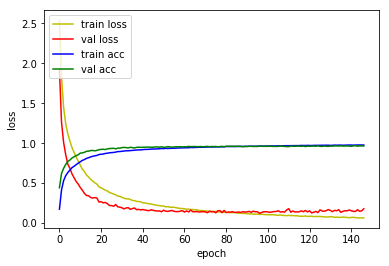

4815/4815 [==============================] - 2s 404us/sample - loss: 0.1870 - acc: 0.9485
Loss: 0.18697071116367356 Accuracy: 0.9484943



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_32_DO_075_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_32_DO_075_DO'

i = 8
model_name = base+'_{}_conv'.format(i)
print()
print(model_name, 'Model')
model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
model_filename = model_path + sorted(os.listdir(model_path))[-1]

model = load_model(model_filename)
model.summary()

[loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
print('Loss:', loss, 'Accuracy:', accuracy)

# del(model)


1D_CNN_custom_ch_32_DO_075_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_68 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
activation_69 (Activation)   (No

In [59]:
# dir(model.layers[0])
x1w = model.layers[0].get_weights()[0]
x1w, x1w[:,0,0]
# x1w = x1w[0][0]
# x1w

(array([[[-0.3106074 ,  0.13599136,  0.39478263, -0.5487611 ,
           0.04834766, -0.34348977, -0.09238157,  0.20059726,
           0.09414005,  0.41970667, -0.13299997,  0.56170446,
           0.4656292 , -0.27239114,  0.31932655,  0.00388216,
           0.42863008,  0.47777995,  0.34016943, -0.3179274 ,
           0.2721707 ,  0.3997097 ,  0.58544356,  0.24919471,
          -0.09690873, -0.28347325,  0.39864233, -0.6718644 ,
          -0.5072978 , -0.2002464 ,  0.07500112,  0.13127115]],
 
        [[ 0.2190911 ,  0.5089676 , -0.19251813, -0.5095081 ,
           0.08009236,  0.21228306,  0.02794367, -0.00592784,
           0.07415169,  0.03490736,  0.10092944, -0.3860515 ,
           0.04208849,  0.22005434,  0.38621005,  0.09656194,
          -0.05904865,  0.10112352, -0.27672917, -0.11816657,
           0.10031383, -0.17889047, -0.29038706, -0.08941289,
          -0.4585213 , -0.10899372,  0.19605844, -0.05961814,
           0.06720591,  0.09473217, -0.05715673,  0.19696848]],
 


In [61]:
import matplotlib.pyplot as plt

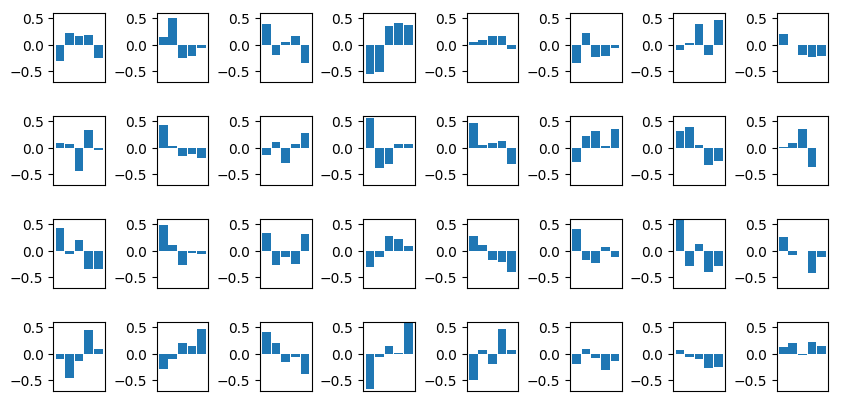

In [142]:
x1w = model.layers[0].get_weights()[0]

plt.figure(figsize=(10, 5), dpi=100)
plt.subplots_adjust(wspace=1, hspace=0.5)

y_min = np.around(x1w[:,0].min(), decimals=1)
y_max = np.around(x1w[:,0].max(), decimals=1)

for i in range(32):
    plt.subplot(4,8,i+1)
    plt.ylim(y_min, y_max)
    plt.xticks([])
#     plt.title('CH '+str(i))
    target_filter = x1w[:,0,i]
    plt.bar(np.arange(len(target_filter)), target_filter, width=0.9)
plt.show()

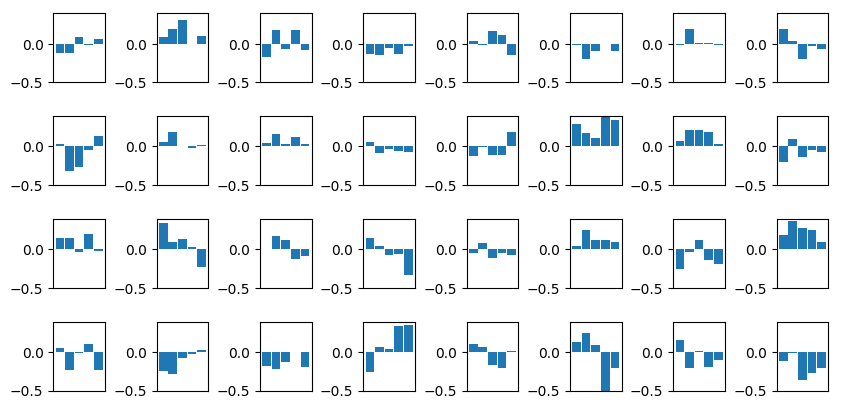

In [143]:
x1w = model.layers[2].get_weights()[0]

plt.figure(figsize=(10, 5), dpi=100)
plt.subplots_adjust(wspace=1, hspace=0.5)

y_min = np.around(x1w[:,0].min(), decimals=1)
y_max = np.around(x1w[:,0].max(), decimals=1)

for i in range(32):
    plt.subplot(4,8,i+1)
    plt.ylim(y_min, y_max)
    plt.xticks([])
#     plt.title('CH '+str(i))
    target_filter = x1w[:,0,i]
    plt.bar(np.arange(len(target_filter)), target_filter, width=0.9)
plt.show()

In [ ]:
model.evaluate(x_test_abs, y_test_onehot)

In [144]:
from sklearn.metrics import classification_report, confusion_matrix

In [148]:
Y_pred = model.predict(x_test_abs)
y_pred = np.argmax(Y_pred, axis=1)

y_real = np.argmax(y_test_onehot, axis=1)

print('Confusion Matrix')
print(confusion_matrix(y_real, y_pred))
# print('Classification Report')
# target_names = ['Cats', 'Dogs', 'Horse']
# print(classification_report(y_test_onehot, y_pred, target_names=target_names))

Confusion Matrix
[[369   0   5   1   3   0   1   4   0   1   0   0   1   0   0   0]
 [  1 347   0   0   4   1   1   0   0   7   2   0   0   1   0   0]
 [  8   0 369   2   0   0   0   0   1   0   0   0   2   2   0   0]
 [  1   0   2 356   0   1   1   2   6   0   0   0   0   0   0   8]
 [  2   2   1   1 359   2   0   0   0   0   0   0   1   0   0   0]
 [  0   6   0   3   4 386   0   2   1   3   0   1   2   0   0   0]
 [  0   0   0   3   1   0 366   1   2   0   1   0   0   0   0   0]
 [  3   0   0   0   1   0   2 367   0   0   3   0   0   0   0   0]
 [  1   0   1   2   1   0   0   0 367   0   2   0   1   0   0   1]
 [  0   6   0   0   0   3   0   0   0 364   3   1   0   0   0   0]
 [  1   0   2   0   0   0   0   0   6   0 166   5   2   1   0   0]
 [  0   1   1   1   0   0   2   0   0   2   7 137   0   2   0   0]
 [  0   0   0   0   0   0   0   1   0   0   1   0 161   4   1   0]
 [  0   1   5   0   0   0   0   0   0   1   1   0   2 182   0   0]
 [  0   0   2   0   0   1   1   0   0   1   0

In [154]:
y_table.T[0]

array(['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',
       'eight', 'nine', 'bed', 'bird', 'cat', 'dog', 'house', 'tree'],
      dtype='<U5')